# Solar Power and Gas Substitution

This notebook explores whether increased solar power generation in EU countries is displacing natural gas in electricity production.

## Key findings:
- **Clear substitution trend**: In many countries, solar output has increased while gas usage has decreased — especially in warmer, sunnier countries like Spain and Italy.
- **Country comparison**: The analysis highlights varying speeds of the solar transition. For instance, Germany shows strong growth in solar, while Poland remains more reliant on fossil fuels.
- **Environmental gain**: We estimate how much CO₂ has been avoided through this substitution, reinforcing the environmental value of expanding solar generation.

The notebook demonstrates how SDMX data enables evidence-based assessments of decarbonisation progress in the energy sector.

This program will try to estimate the price saving for european countries based on very simplified asumptions due to the intorduction of solar energy.

It will fetch data from Eurostat database using pysdmx.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from utils import utils

# Countries of interest
geo_list = ["ES", "FR", "IT", "DE", "PL"]

# Query definition
solar_constraints  = {
    'freq': 'A',
    'nrg_bal': 'GEP',
    'siec': ['RA100', 'RA130', 'RA300', 'RA410', 'RA420', 'G3000', 'C0000X0350-0370', 'N900H', 'TOTAL'],  # RA100: Hydro, RA130: Pumped Hydro, RA300: Eólica, RA400: Solar Thermal, RA400: Solar Photo, G3000: Gas, C0000X0350-0370: Carbón
    'unit': 'GWH',
    'geo': geo_list,
}

# 1.- Data download
# with this query, defined in "solar_constraints", we download all the needed data
datos = utils.get_dataset_with_selection('nrg_bal_peh', solar_constraints)
renewables_production = datos.data # type: ignore

# data pivot for convenience
pivot_data = renewables_production.pivot_table(
    index=['TIME_PERIOD', 'geo'],
    columns='siec',
    values='OBS_VALUE',
    aggfunc='sum'
).reset_index().rename(columns={
    'RA100':'hydro_GWh', 
    'RA130':'pumped_hydro_GWh', 
    'RA300':'wind_GWh', 
    'RA410':'solar_therm_GWh', 
    'RA420':'solar_photo_GWh', 
    'G3000':'gas_GWh',
    'C0000X0350-0370':'coal_GWh',
    'N900H': 'nuclear_GWh',
    'TOTAL':'total_GWh'})

# Calculating percentages
pivot_data['Total_no_hydro_nuc'] = pivot_data['total_GWh'] - (pivot_data['hydro_GWh'] + pivot_data['pumped_hydro_GWh'] + pivot_data['nuclear_GWh'])
pivot_data['solar_GWh'] = pivot_data['solar_therm_GWh'] + pivot_data['solar_photo_GWh']
pivot_data['renewables_%'] = 100 * (pivot_data['wind_GWh'] + pivot_data['solar_therm_GWh'] + pivot_data['solar_photo_GWh']) / pivot_data['Total_no_hydro_nuc']
pivot_data['gas_%'] = 100 * pivot_data['gas_GWh'] / pivot_data['Total_no_hydro_nuc']
pivot_data['coal_%'] = 100 * pivot_data['coal_GWh'] / pivot_data['Total_no_hydro_nuc']
pivot_data['fossil_%'] = pivot_data['gas_%'] + pivot_data['coal_%']


data_url: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/nrg_bal_peh/A.GEP.RA100+RA130+RA300+RA410+RA420+G3000+C0000X0350-0370+N900H+TOTAL.GWH.ES+FR+IT+DE+PL?format=SDMX-CSV&startPeriod=2000
metadata_url: https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/dataflow/all/nrg_bal_peh/latest?detail=full&references=descendants


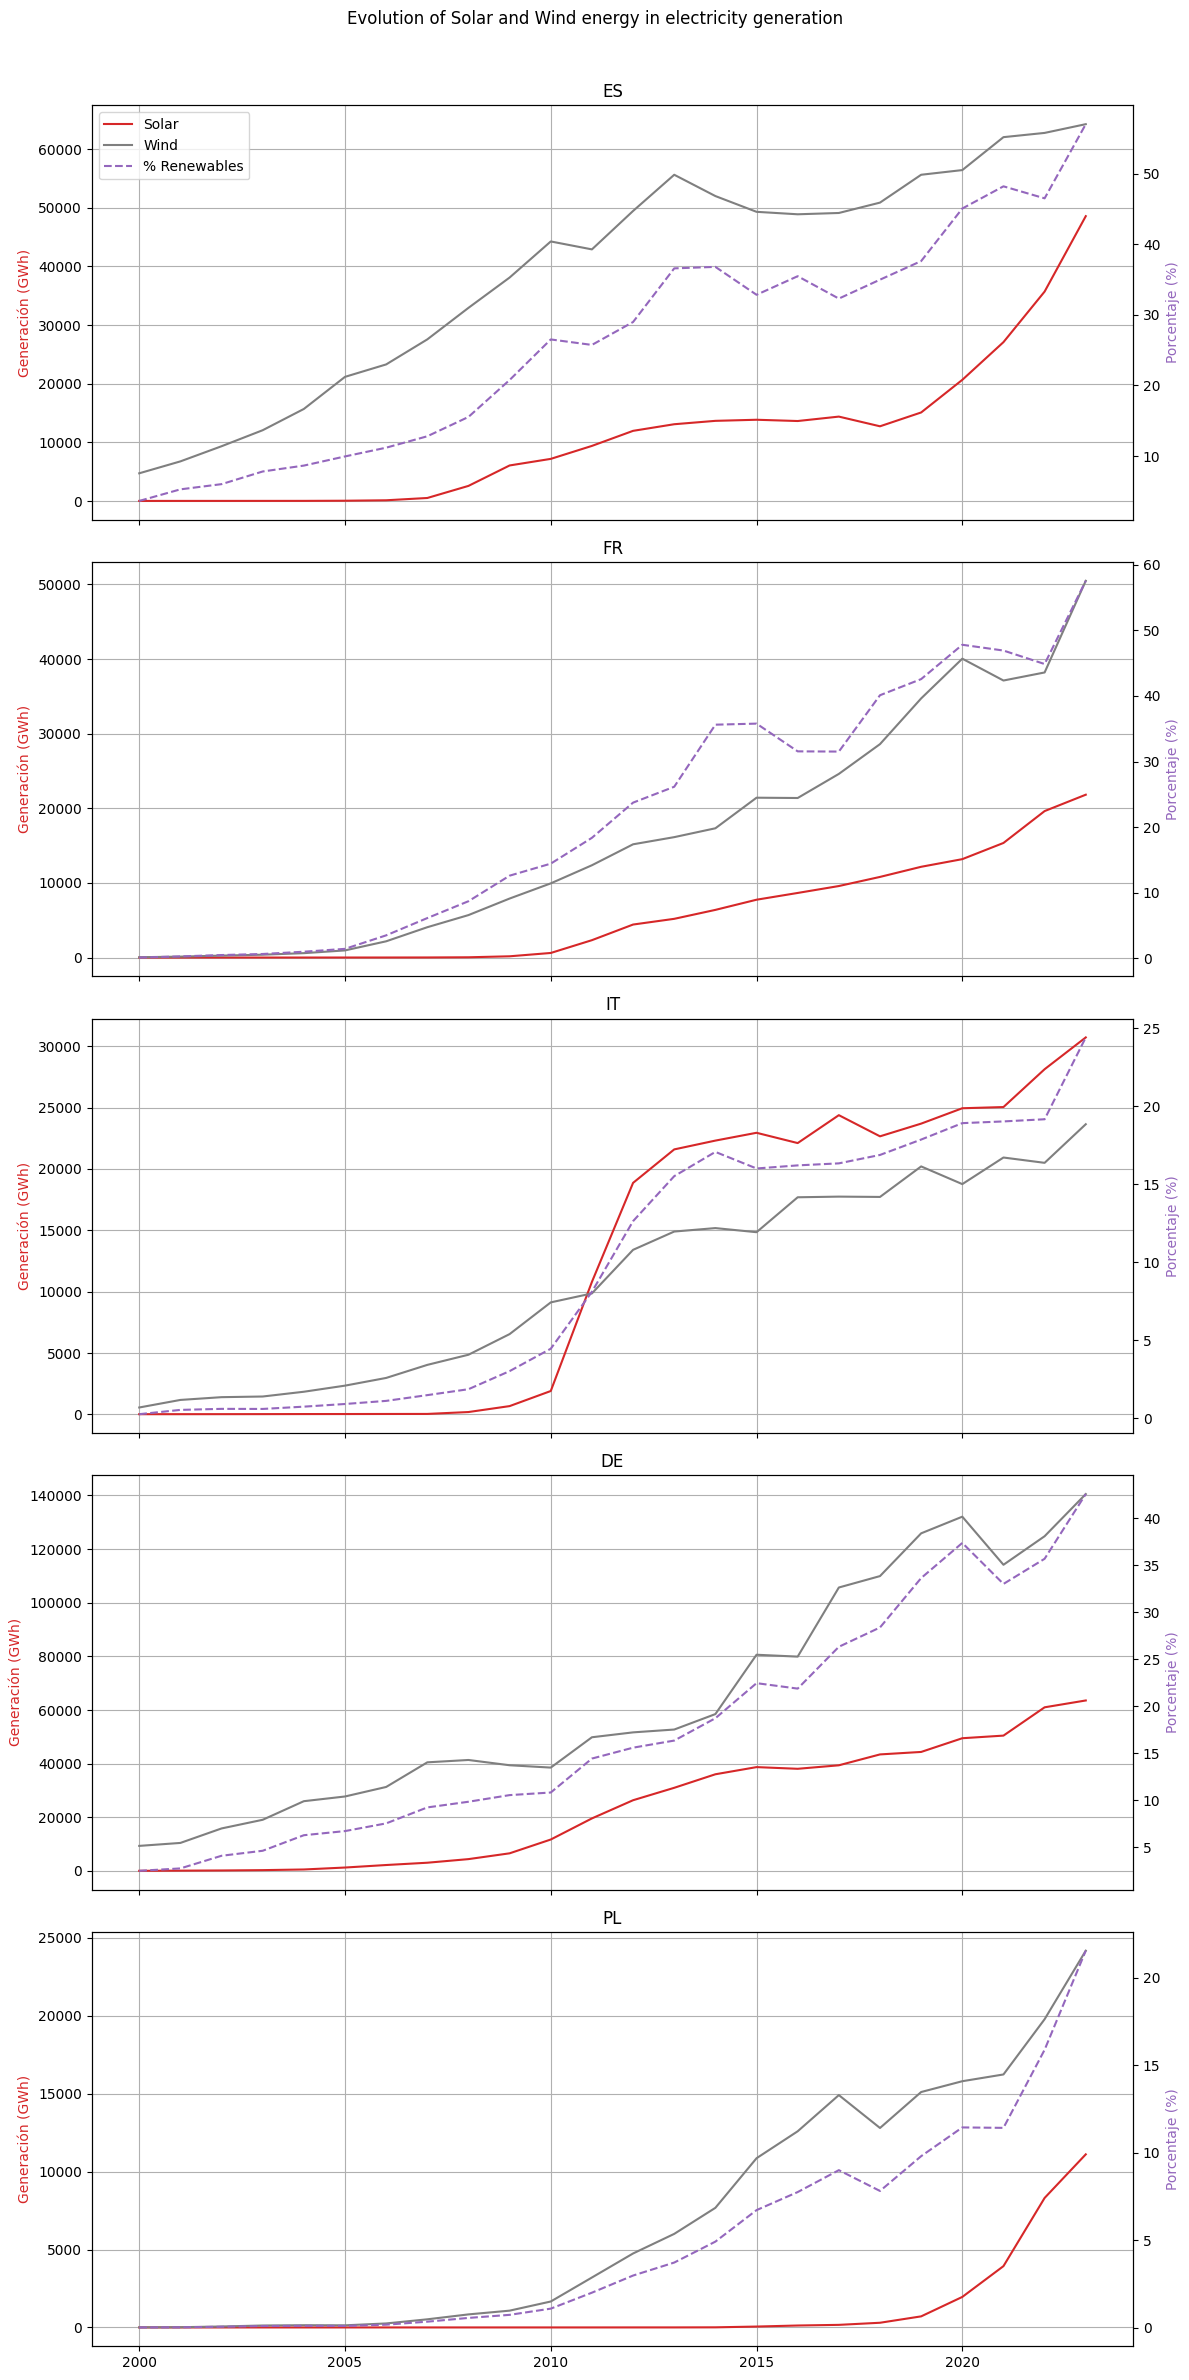

In [2]:

# 1.- Renewable in electricity generation evolution
# We can see how renewables are growing bigger as a part of the electricity generation mix
fig, axes = plt.subplots(len(geo_list), 1, figsize=(12, 25), sharex=True)

for idx, country in enumerate(geo_list):
    country_data = pivot_data[pivot_data['geo'] == country]
    ax1 = axes[idx]

    ax1.plot(country_data['TIME_PERIOD'], country_data['solar_GWh'], label='Solar', color='tab:red')
    ax1.plot(country_data['TIME_PERIOD'], country_data['wind_GWh'], label='Wind', color='tab:gray')
    ax1.set_ylabel('Generación (GWh)', color='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(country_data['TIME_PERIOD'], country_data['renewables_%'], label='% Renewables', linestyle='--', color='tab:purple')
    ax2.set_ylabel('Porcentaje (%)', color='tab:purple')

    ax1.set_title(f'{country}')
    ax1.grid()
    
    # Combine legends from both axes, only shown in first chart
    if idx == 0:
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')

fig.suptitle('Evolution of Solar and Wind energy in electricity generation')
fig.tight_layout(rect=(0, 0.03, 1, 0.97))
plt.xlabel('Year')
plt.show()



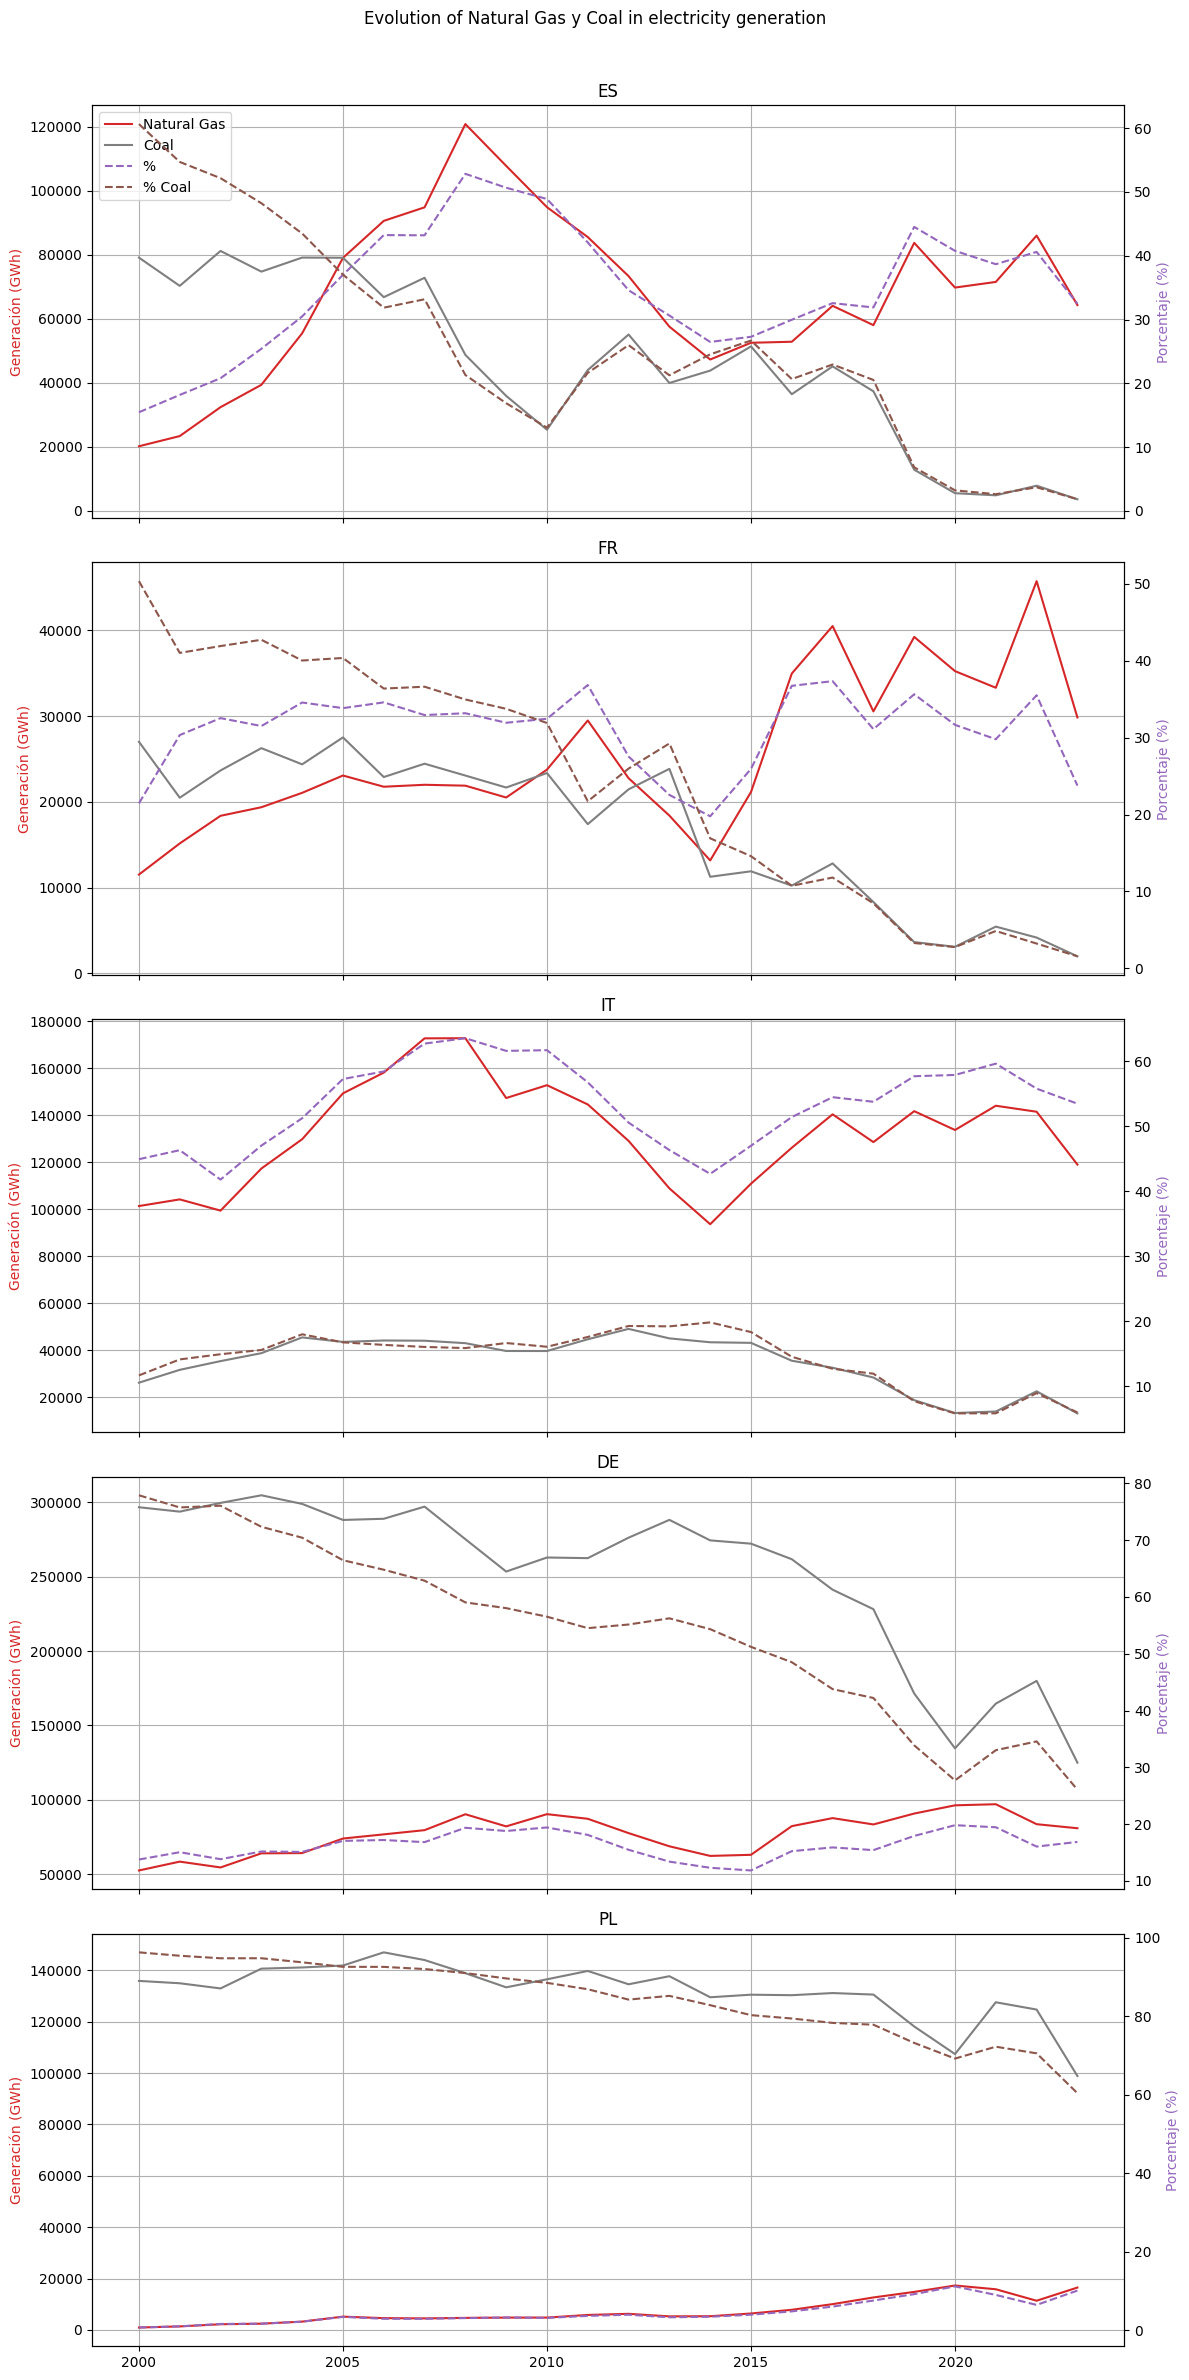

In [3]:
# 2.- Gas and Coal consumption in electricity generation
# On the other hand the picture with fossil fuels is mixed, although clearly in remission
fig, axes = plt.subplots(len(geo_list), 1, figsize=(12, 25), sharex=True)

for idx, country in enumerate(geo_list):
    country_data = pivot_data[pivot_data['geo'] == country]
    ax1 = axes[idx]

    ax1.plot(country_data['TIME_PERIOD'], country_data['gas_GWh'], label='Natural Gas', color='tab:red')
    ax1.plot(country_data['TIME_PERIOD'], country_data['coal_GWh'], label='Coal', color='tab:gray')
    ax1.set_ylabel('Generación (GWh)', color='tab:red')

    ax2 = ax1.twinx()
    ax2.plot(country_data['TIME_PERIOD'], country_data['gas_%'], label='% ', linestyle='--', color='tab:purple')
    ax2.plot(country_data['TIME_PERIOD'], country_data['coal_%'], label='% Coal', linestyle='--', color='tab:brown')
    ax2.set_ylabel('Porcentaje (%)', color='tab:purple')

    ax1.set_title(f'{country}')
    ax1.grid()
    
        # Combine legends from both axes, only shown in first chart
    if idx == 0:
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')

fig.suptitle('Evolution of Natural Gas y Coal in electricity generation')
fig.tight_layout(rect=(0, 0.03, 1, 0.97))
plt.xlabel('Year')
plt.show()



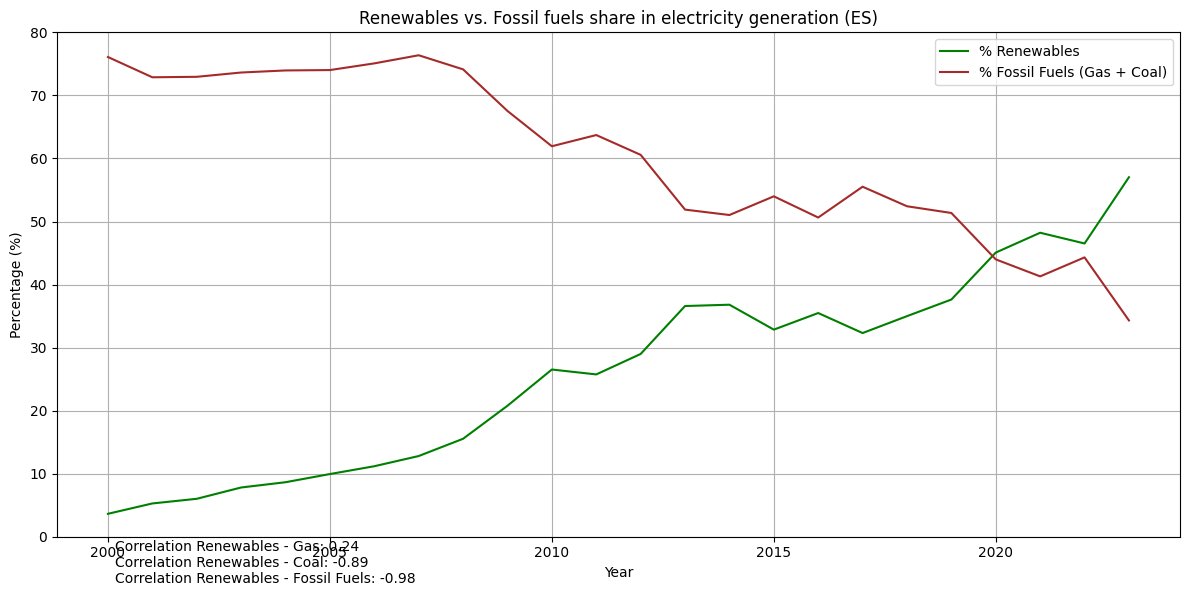

In [4]:
# 3.- Focus on one country, Spain
# 3.1.- Now we are going to see if rise in renewables and decrease in coal and gas is correlated
# Correlation analysis and graph
country = "ES"  # example country: Spain
country_data = pivot_data[pivot_data['geo'] == country]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(country_data['TIME_PERIOD'], country_data['renewables_%'], label='% Renewables', color='green')
ax.plot(country_data['TIME_PERIOD'], country_data['fossil_%'], label='% Fossil Fuels (Gas + Coal)', color='brown')
ax.set_title(f'Renewables vs. Fossil fuels share in electricity generation ({country})')
ax.set_xlabel('Year')
ax.set_ylabel('Percentage (%)')
ax.legend()
ax.grid()

# Correlation calculation
corr_gas = np.corrcoef(country_data['renewables_%'], country_data['gas_%'])[0, 1]
corr_coal = np.corrcoef(country_data['renewables_%'], country_data['coal_%'])[0, 1]
corr_fossil = np.corrcoef(country_data['renewables_%'], country_data['fossil_%'])[0, 1]

# Display correlation
plt.subplots_adjust(bottom=0.3)
plt.figtext(0.1, 0.02, f'Correlation Renewables - Gas: {corr_gas:.2f}\nCorrelation Renewables - Coal: {corr_coal:.2f}\nCorrelation Renewables - Fossil Fuels: {corr_fossil:.2f}', fontsize=10, ha='left')

plt.tight_layout()
plt.show()




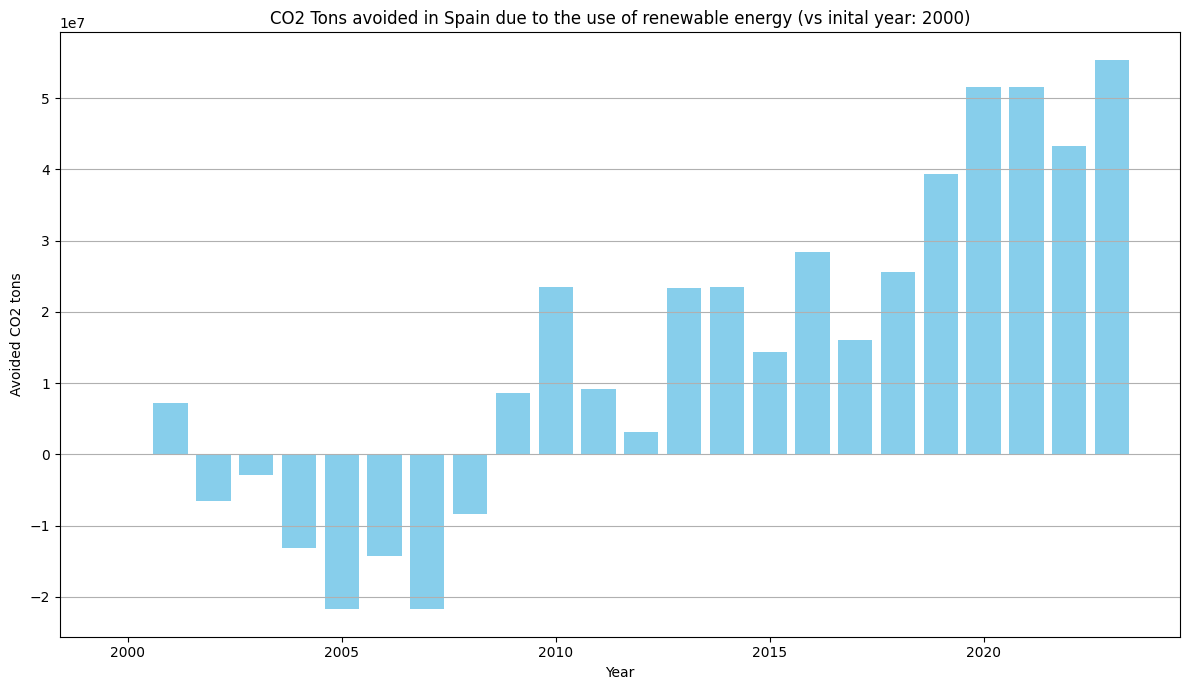

In [10]:
# 3.2.- Now we are going to see if there is correlation between the rise in renewables and lower CO2 emissions
emission_factors = {
    'ES': {'gas':370, 'coal':950 },
    'FR': {'gas':429, 'coal':986},
    'IT': {'gas':370, 'coal':900},
    'DE': {'gas':350, 'coal':940},
    'PL': {'gas':450, 'coal':900}
}    # CO2 tons / GWh

# Calculate avoided emissions (in tons of CO2)
country_data = pivot_data[pivot_data['geo'] == country].copy()  # Create explicit copy
country_data['avoided_gas_GWh'] = country_data['gas_GWh'].iloc[0] - country_data['gas_GWh']
country_data['avoided_coal_GWh'] = country_data['coal_GWh'].iloc[0] - country_data['coal_GWh']
country_data['avoided_CO2_tons'] = (country_data['avoided_gas_GWh'] * emission_factors[country]['gas'] +
                                    country_data['avoided_coal_GWh'] * emission_factors[country]['coal'])


# Plot avoided CO2 emissions
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(country_data['TIME_PERIOD'], country_data['avoided_CO2_tons'], color='skyblue')
ax.set_title(f'CO2 Tons avoided in Spain due to the use of renewable energy (vs inital year: {country_data["TIME_PERIOD"].iloc[0]})')
ax.set_xlabel('Year')
ax.set_ylabel('Avoided CO2 tons')
ax.grid(axis='y')

plt.tight_layout()
plt.show()



